## Hugging Face ASR Competition 
### Read data (SPANISH)



In [1]:
##dependencies
!pip install datasets==1.13.3
!pip install transformers==4.11.3
!pip install huggingface_hub==0.1
!pip install jiwer

UsageError: Line magic function `%%capture` not found.


In [19]:
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [1]:
from datasets import load_dataset, load_metric, Audio
import torchaudio
torchaudio.set_audio_backend("soundfile")


common_voice_train = load_dataset("common_voice", "es", split="train+validation")
common_voice_test = load_dataset("common_voice", "es", split="test")

Reusing dataset common_voice (C:\Users\jhonp\.cache\huggingface\datasets\common_voice\es\6.1.0\f7a9d973839b7706e9e281c19b7e512f31badf3c0fdbd21c671f3c4bf9acf3b9)
Reusing dataset common_voice (C:\Users\jhonp\.cache\huggingface\datasets\common_voice\es\6.1.0\f7a9d973839b7706e9e281c19b7e512f31badf3c0fdbd21c671f3c4bf9acf3b9)


In [2]:
common_voice_train['audio'][0]

ImportError: To support decoding 'mp3' audio files, please install 'sox'.

### Exploring Dataset

Explore dataset and feature variability

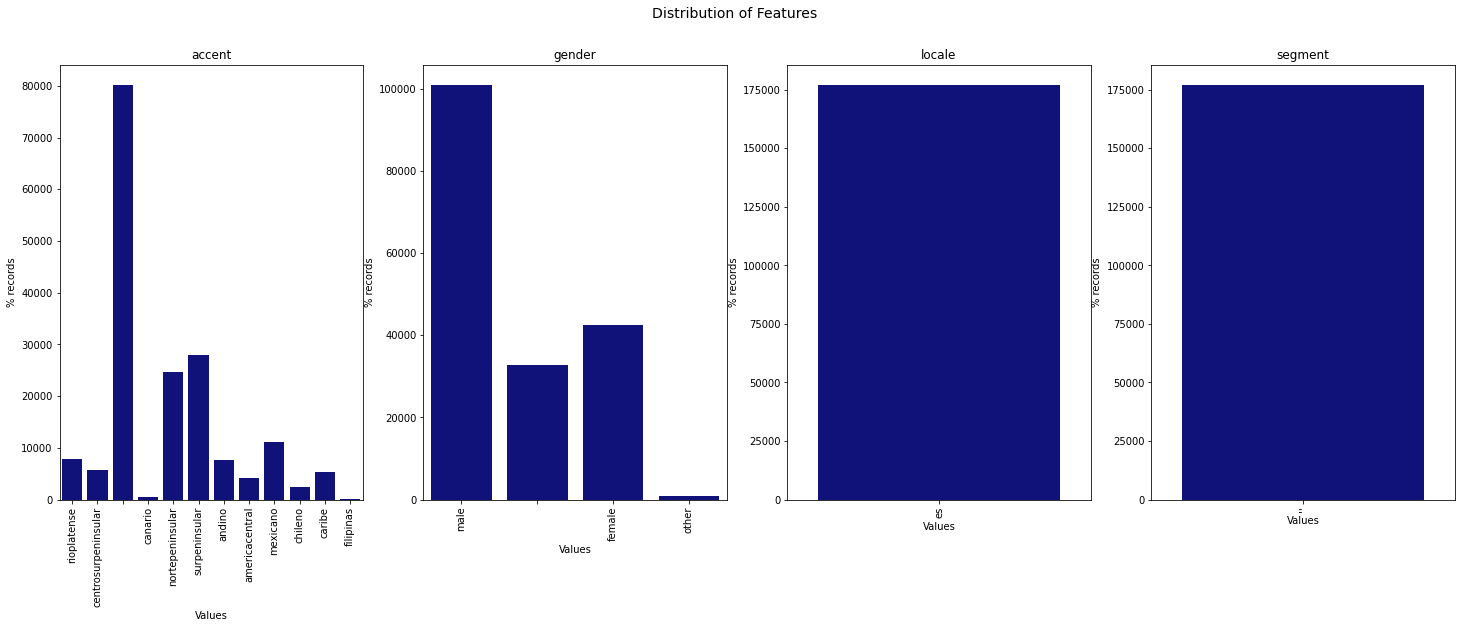

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(25,8))
columns_explore=["accent", "gender", "locale", "segment"]
for i in range(len(columns_explore)):
    datac=common_voice_train[columns_explore[i]]
    ax=fig.add_subplot(1,4,i+1)
    sns.countplot(x=datac,color="darkblue",ax=ax)
    ax.set_ylabel("% records")
    ax.set_xlabel("Values")
    ax.set_title(columns_explore[i])
    plt.xticks(rotation=90);
fig.suptitle("Distribution of Features",size=14);

In [2]:
common_voice_train = common_voice_train.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])
common_voice_test = common_voice_test.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])

In [3]:
### cleaning text auxiliar functions
import re
def clean_batch(batch):
    batch["sentence"] = re.sub("([^A-Za-zÀ-ú ])", '', batch["sentence"]).lower()
    batch["sentence"]= re.sub("([ß|þ|ð|æ])",'',batch['sentence'])
    return batch

def homologate_accents(batch):
    batch["sentence"]=re.sub("([â|ã|ä|å|à])","a",batch["sentence"])
    batch["sentence"]=re.sub("([é|ê|ë])","e",batch["sentence"])
    batch["sentence"]=re.sub("([ì|î|ï])","i",batch["sentence"])
    batch["sentence"]=re.sub("([ö|õ|ô|ò|ø])","o",batch["sentence"])
    batch["sentence"]=re.sub("ù","u",batch["sentence"])
    batch["sentence"]=re.sub("ç","c",batch["sentence"])
    
    return batch

In [4]:
##apply it for every audio

common_voice_train = common_voice_train.map(clean_batch)
common_voice_train = common_voice_train.map(homologate_accents)
common_voice_test = common_voice_test.map(clean_batch)
common_voice_test = common_voice_test.map(homologate_accents)

Loading cached processed dataset at C:\Users\jhonp\.cache\huggingface\datasets\common_voice\es\6.1.0\f7a9d973839b7706e9e281c19b7e512f31badf3c0fdbd21c671f3c4bf9acf3b9\cache-e3054ad04b4e5cf4.arrow
Loading cached processed dataset at C:\Users\jhonp\.cache\huggingface\datasets\common_voice\es\6.1.0\f7a9d973839b7706e9e281c19b7e512f31badf3c0fdbd21c671f3c4bf9acf3b9\cache-48b87361ee631ad3.arrow
Loading cached processed dataset at C:\Users\jhonp\.cache\huggingface\datasets\common_voice\es\6.1.0\f7a9d973839b7706e9e281c19b7e512f31badf3c0fdbd21c671f3c4bf9acf3b9\cache-c75dd875821d6238.arrow
Loading cached processed dataset at C:\Users\jhonp\.cache\huggingface\datasets\common_voice\es\6.1.0\f7a9d973839b7706e9e281c19b7e512f31badf3c0fdbd21c671f3c4bf9acf3b9\cache-34e62c50fa610234.arrow


### Generate Vocabulary

In [5]:
def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [6]:
vocab_train = common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)
vocab_test = common_voice_test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_test.column_names)

100%|██████████| 1/1 [00:00<00:00, 20.83ba/s]


In [7]:
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]))
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
print(vocab_dict)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, 'á': 27, 'í': 28, 'ñ': 29, 'ó': 30, 'ú': 31}


In [8]:
## add a special character for empty value
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [9]:
##add unknown and padding tokens
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

34

In [10]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [11]:
from transformers import Wav2Vec2CTCTokenizer
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("./", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

file ./config.json not found
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Upload Tokenizer to Repo

In [41]:
repo_name = "wav2vec2-large-xls-r-300m-spanish-custom"
tokenizer.push_to_hub(repo_name)

C:\Users\jhonp\miniconda3\lib\site-packages\huggingface_hub\hf_api.py:715: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  warnings.warn(
Cloning https://huggingface.co/jhonparra18/wav2vec2-large-xls-r-300m-spanish-custom into local empty directory.
To https://huggingface.co/jhonparra18/wav2vec2-large-xls-r-300m-spanish-custom
   b330905..752cf1e  main -> main



'https://huggingface.co/jhonparra18/wav2vec2-large-xls-r-300m-spanish-custom/commit/752cf1e58b38777632a567058198bc848acfdd87'

### Model Definition

In [22]:
%pip install PySoundFile

Note: you may need to restart the kernel to use updated packages.


In [12]:

from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

In [13]:
from transformers import Wav2Vec2Processor
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [14]:
##convert to 16000 hz
common_voice_train = common_voice_train.cast_column("audio", Audio(sampling_rate=16000))
common_voice_test = common_voice_test.cast_column("audio", Audio(sampling_rate=16000))

In [6]:
##listen to random audio and its text
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(common_voice_train)-1)

print(common_voice_train[rand_int]["sentence"])
#ipd.Audio(data=common_voice_train[rand_int]["audio"]["array"], autoplay=True, rate=16000)

ImportError: To support decoding 'mp3' audio files, please install 'sox'.

In [16]:
rand_int = random.randint(0, len(common_voice_train)-1)

print("Target text:", common_voice_train[rand_int]["sentence"])
print("Input array shape:", common_voice_train[rand_int]["audio"]["array"].shape)
print("Sampling rate:", common_voice_train[rand_int]["audio"]["sampling_rate"])

ImportError: To support decoding 'mp3' audio files, please install 'sox'.